## 探索数据

### 导入数据
通过 Pandas 库从数据集文件分别导入数据至 `data_train`、`data_test` 和 `data_store` 三个数据帧（_DataFrame_），即训练集、测试集和商店补充数据集。

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

% matplotlib inline

sns.set(style='whitegrid', palette='muted')

data_train = pd.read_csv('data/train.csv',
                         dtype={
                             'StateHoliday': 'category',
                             'SchoolHoliday': 'category'},
                         parse_dates=['Date'])
data_test = pd.read_csv('data/test.csv',
                        dtype={
                            'StateHoliday': 'category',
                            'SchoolHoliday': 'category'},
                        parse_dates=['Date'])
data_store = pd.read_csv('data/store.csv',
                         dtype={
                             'StoreType': 'category',
                             'Assortment': 'category',
                             'CompetitionOpenSinceMonth': float,
                             'CompetitionOpenSinceYear': float,
                             'Promo2': float,
                             'Promo2SinceWeek': float,
                             'Promo2SinceYear': float})

### 检查数据

为方便分析，通过 _Store_ 字段索引联合合并 `data_train` 与 `data_store` 数据集到同一数据集中。合并后的 `data_train` 包含原有字段以及对应的商店信息。

In [2]:
data_train = pd.merge(data_train, data_store, on='Store', how='left')
data_train.head(5)

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0.0,NaN,NaN,NaN
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1.0,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1.0,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,9.0,2009.0,0.0,NaN,NaN,NaN
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,4.0,2015.0,0.0,NaN,NaN,NaN


#### 缺失值和异常值
输出并观察训练集 `data_train` 的基本信息和统计量：

In [3]:
print('Total number of samples:', data_train.shape[0])
print('')
data_train.info()
print('')
print(data_train.iloc[:, 1:].describe())

Total number of samples: 1017209

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1017209 entries, 0 to 1017208
Data columns (total 18 columns):
Store                        1017209 non-null int64
DayOfWeek                    1017209 non-null int64
Date                         1017209 non-null datetime64[ns]
Sales                        1017209 non-null int64
Customers                    1017209 non-null int64
Open                         1017209 non-null int64
Promo                        1017209 non-null int64
StateHoliday                 1017209 non-null category
SchoolHoliday                1017209 non-null category
StoreType                    1017209 non-null category
Assortment                   1017209 non-null category
CompetitionDistance          1014567 non-null float64
CompetitionOpenSinceMonth    693861 non-null float64
CompetitionOpenSinceYear     693861 non-null float64
Promo2                       1017209 non-null float64
Promo2SinceWeek              509178 non-null f

Missing value counts:
Store                             0
DayOfWeek                         0
Date                              0
Sales                             0
Customers                         0
Open                              0
Promo                             0
StateHoliday                      0
SchoolHoliday                     0
StoreType                         0
Assortment                        0
CompetitionDistance            2642
CompetitionOpenSinceMonth    323348
CompetitionOpenSinceYear     323348
Promo2                            0
Promo2SinceWeek              508031
Promo2SinceYear              508031
PromoInterval                508031
dtype: int64


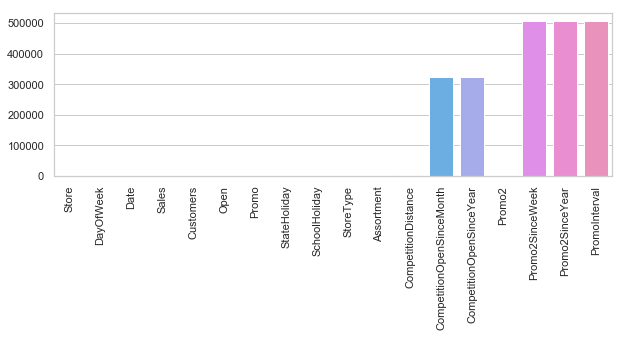

In [4]:
counts = data_train.isnull().sum()
print('Missing value counts:')
print(counts)
plt.figure(figsize=(10, 3))
g = sns.barplot(counts.index, counts.values)
g.set_xticklabels(g.get_xticklabels(), rotation=90)
plt.show()

训练集 `data_train` 共包含 1017209 个数据样本。若干字段存在数据缺失情况：_CompetitionDistance_, _CompetitionOpenSinceMonth_, _CompetitionOpenSinceYear_, _Promo2SinceWeek_, _Promo2SinceYear_ 和 _PromoInterval_。其中 _CompetitionDistance_ 为连续数值变量，可通过均值补全缺失数据。由于该项目将采用 XGBoost 构建模型，默认情况下 XGBoost 支持缺失值（树算法在训练期间学习缺失值的分叉方向），可令 XGBoost 自动处理其它分类变量的缺失数据。

绘制 _Sales_、_Customers_ 和 _CompetitionDistance_ 的频率直方图和箱线图：

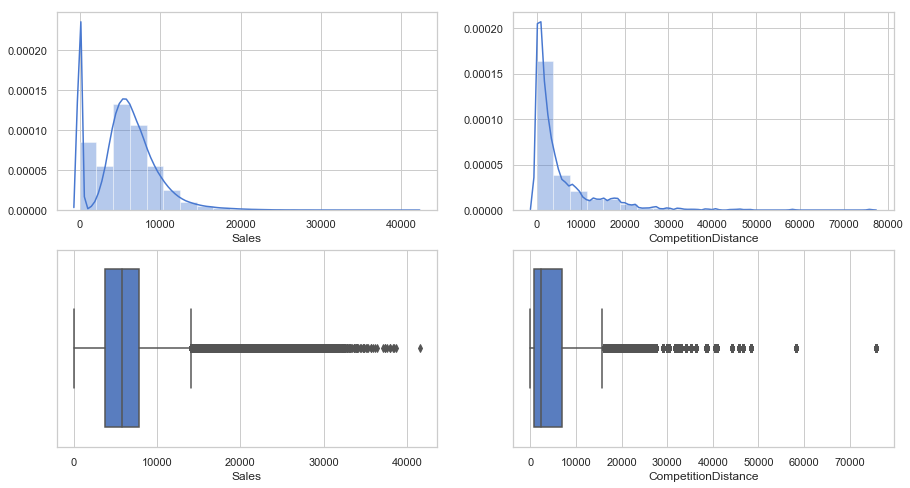

In [5]:
fig, axes = plt.subplots(2, 2, figsize=(15, 8))
sns.distplot(data_train['Sales'].dropna(), bins=20, ax=axes[0][0]);
sns.distplot(data_train['CompetitionDistance'].dropna(), bins=20, ax=axes[0][1]);
sns.boxplot(x=data_train['Sales'].dropna(), ax=axes[1][0])
sns.boxplot(x=data_train['CompetitionDistance'].dropna(), ax=axes[1][1])
plt.show()

从上图可发现在 _Sales_、_Customers_ 和 _CompetitionDistance_ 三个字段均存在异常值。 

### 可视化数据

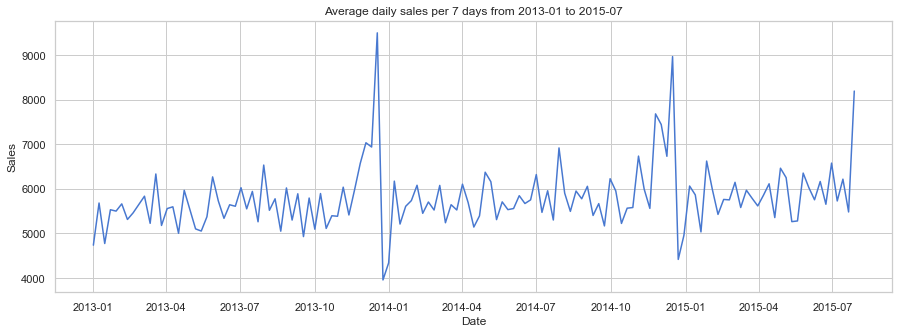

In [6]:
plt.figure(figsize=(15, 5))
data_train_sales = data_train[['Date', 'Sales']]
data_train_sales_1 = data_train_sales.groupby(pd.Grouper(key='Date', freq='7D')).mean()
ax = sns.lineplot(x=data_train_sales_1.index, y=data_train_sales_1['Sales'])
ax.set_title('Average daily sales per 7 days from 2013-01 to 2015-07')
plt.show()

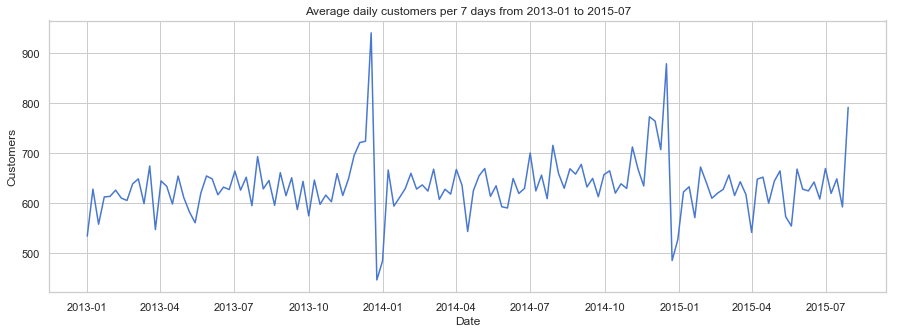

In [7]:
plt.figure(figsize=(15, 5))
data_train_customers = data_train[['Date', 'Customers']]
data_train_customers_1 = data_train_customers.groupby(pd.Grouper(key='Date', freq='7D')).mean()
ax = sns.lineplot(x=data_train_customers_1.index, y=data_train_customers_1['Customers'])
ax.set_title('Average daily customers per 7 days from 2013-01 to 2015-07')
plt.show()

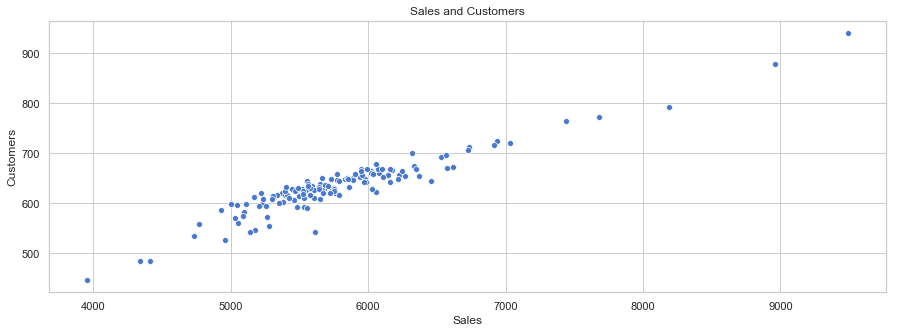

In [8]:
plt.figure(figsize=(15, 5))
sns.scatterplot(x=data_train_sales_1['Sales'], y=data_train_customers_1['Customers']).set_title('Sales and Customers')
plt.show()

In [9]:
data_train_open_sl_cstm = data_train[['Sales', 'Customers']]
data_train_open_sl_cstm.corr()

,Sales,Customers
Sales,1.000000,0.894711
Customers,0.894711,1.000000


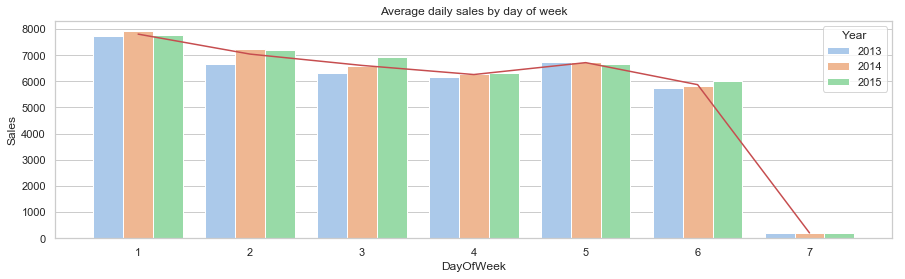

In [10]:
plt.figure(figsize=(15, 4))
data_train_wd = data_train.copy()
data_train_wd['Year'] = data_train_wd['Date'].dt.strftime('%Y')
data_train_wd = data_train_wd.groupby(['Year', 'DayOfWeek']).mean().reset_index()
sns.barplot(x='DayOfWeek', y='Sales', hue='Year', palette='pastel', data=data_train_wd)
data_train_wd = data_train_wd.groupby(['DayOfWeek']).mean().reset_index()
ax = sns.lineplot(x=data_train_wd.index, y=data_train_wd['Sales'], color='#c64d4f')
ax.set_title('Average daily sales by day of week')
ax.legend_.set_title('Year')
plt.show()

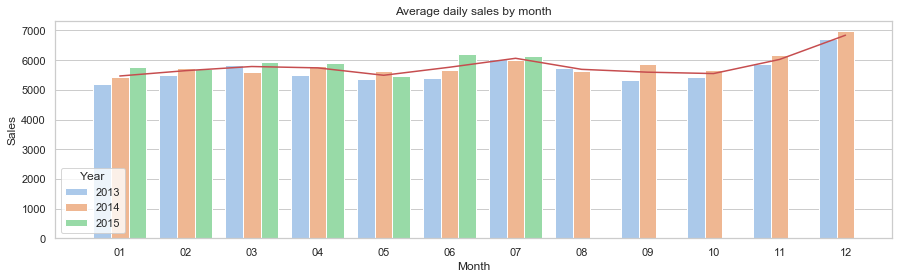

In [11]:
plt.figure(figsize=(15, 4))
data_train_m = data_train.copy()
data_train_m['Year'] = data_train_m['Date'].dt.strftime('%Y')
data_train_m['Month'] = data_train_m['Date'].dt.strftime('%m')
data_train_m = data_train_m.groupby(['Year', 'Month']).mean().reset_index()
sns.barplot(x='Month', y='Sales', hue='Year', palette='pastel', data=data_train_m)
data_train_m = data_train_m.groupby(['Month']).mean().reset_index()
ax = sns.lineplot(x=data_train_m.index, y=data_train_m['Sales'], color='#c64d4f')
ax.set_title('Average daily sales by month')
ax.legend_.set_title('Year')
plt.show()

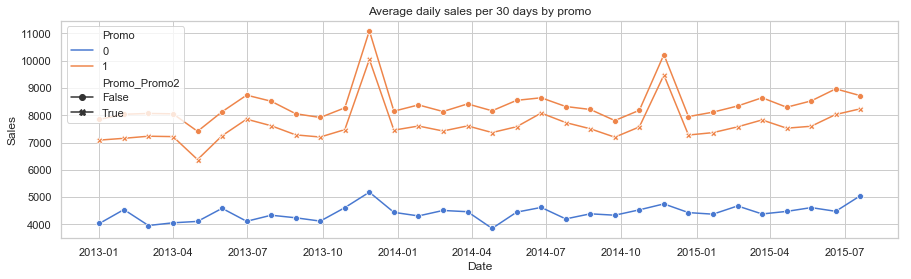

In [12]:
plt.figure(figsize=(15, 4))
data_train_ = data_train.copy()
data_train_ = data_train_[['Sales', 'Date', 'Promo', 'Promo2']]
data_train_['Promo_Promo2'] = data_train_['Promo'] & data_train_['Promo2']
data_train_ = data_train_.groupby([pd.Grouper(key='Date', freq='30D'), 'Promo', 'Promo_Promo2']).mean().reset_index()
ax = sns.lineplot(x='Date', y='Sales', hue='Promo', style='Promo_Promo2', data=data_train_, markers=True, dashes=False)
ax.set_title('Average daily sales per 30 days by promo')
plt.show()

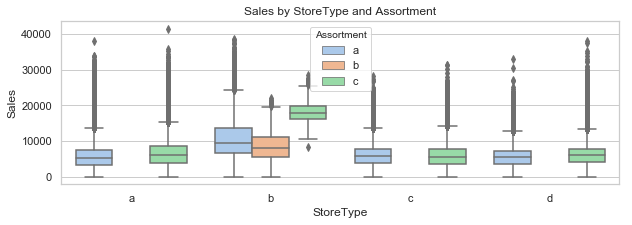

In [13]:
plt.figure(figsize=(10, 3))
ax = sns.boxplot(x='StoreType', y='Sales', hue='Assortment', palette='pastel', data=data_train)
ax.set_title('Sales by StoreType and Assortment')
plt.show()

## 数据预处理

In [1]:
from utils import preprocessing, cv, model
from sklearn.externals import joblib
import pandas as pd
import numpy as np

data_train, data_test, data_store = preprocessing.read_csv(['data/train.csv', 'data/test.csv', 'data/store.csv'])
data_train = preprocessing.combine(data_train, data_store)
X_train, y_train = preprocessing.transform(data_train, dtype='train')

In [2]:
pd.set_option('display.max_columns', None)  
pd.set_option('display.expand_frame_repr', False)
pd.set_option('max_colwidth', -1)
X_train

,Store,DayOfWeek,Open,Promo,SchoolHoliday,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Year,Month,Day,DayOfYear,WeekOfYear,CompetitionOpen,Promo2Open,InPromoMonth,StoreType_a,StoreType_b,StoreType_c,StoreType_d,Assortment_a,Assortment_b,Assortment_c
1017190,1097,1,1,0,1,6.580639,3.0,2002.0,0.0,2013,1,1,1,1,130.0,0.00,0,0,1,0,0,0,1,0
1016179,85,1,1,0,1,7.534228,10.0,2011.0,0.0,2013,1,1,1,1,15.0,0.00,0,0,1,0,0,1,0,0
1016353,259,1,1,0,1,5.351858,NaN,NaN,0.0,2013,1,1,1,1,0.0,0.00,0,0,1,0,0,0,1,0
1016356,262,1,1,0,1,7.074117,5.0,2013.0,0.0,2013,1,1,1,1,0.0,0.00,0,0,1,0,0,1,0,0
1016368,274,1,1,0,1,8.200014,NaN,NaN,1.0,2013,1,1,1,1,0.0,0.00,1,0,1,0,0,0,1,0
1016429,335,1,1,0,1,4.510860,NaN,NaN,1.0,2013,1,1,1,1,0.0,0.00,1,0,1,0,0,1,0,0
1016447,353,1,1,0,1,6.803505,NaN,NaN,1.0,2013,1,1,1,1,0.0,0.00,0,0,1,0,0,0,1,0
1016517,423,1,1,0,1,7.147559,5.0,2014.0,0.0,2013,1,1,1,1,0.0,0.00,0,0,1,0,0,1,0,0
1017042,948,1,1,0,1,7.266129,NaN,NaN,0.0,2013,1,1,1,1,0.0,0.00,0,0,1,0,0,0,1,0
1016606,512,1,1,0,1,6.381816,NaN,NaN,1.0,2013,1,1,1,1,0.0,0.00,0,0,1,0,0,0,1,0


## 执行过程

In [3]:
params = {
    'eta': 0.03,
    'max_depth': 10,
    'min_child_weight': 2,
    'subsample': 0.9,
    'colsample_bytree': 0.7,
    'silent': 1,
    'seed': 10
}

m = model.Model(params, num_boost_round=4500, early_stopping_rounds=100)
m.train(X_train, y_train)

[0]	eval-rmse:8.10994	train-rmse:8.02021	eval-rmspe:0.915117	train-rmspe:0.914444
Multiple eval metrics have been passed: 'train-rmspe' will be used for early stopping.

Will train until train-rmspe hasn't improved in 100 rounds.
[1]	eval-rmse:7.8669	train-rmse:7.78006	eval-rmspe:0.887611	train-rmspe:0.886976
[2]	eval-rmse:7.63443	train-rmse:7.5472	eval-rmspe:0.861284	train-rmspe:0.860325
[3]	eval-rmse:7.406	train-rmse:7.32134	eval-rmspe:0.835421	train-rmspe:0.834476
[4]	eval-rmse:7.18607	train-rmse:7.10225	eval-rmspe:0.810519	train-rmspe:0.809404
[5]	eval-rmse:6.97054	train-rmse:6.88972	eval-rmspe:0.786121	train-rmspe:0.785085
[6]	eval-rmse:6.76429	train-rmse:6.68359	eval-rmspe:0.762778	train-rmspe:0.761504
[7]	eval-rmse:6.56255	train-rmse:6.48362	eval-rmspe:0.73994	train-rmspe:0.738629
[8]	eval-rmse:6.36581	train-rmse:6.28967	eval-rmspe:0.717673	train-rmspe:0.716442
[9]	eval-rmse:6.17771	train-rmse:6.10156	eval-rmspe:0.696387	train-rmspe:0.694926
[10]	eval-rmse:5.99322	train-rmse:5.9

[97]	eval-rmse:0.499515	train-rmse:0.492458	eval-rmspe:0.054827	train-rmspe:0.054527
[98]	eval-rmse:0.48838	train-rmse:0.481462	eval-rmspe:0.053594	train-rmspe:0.053297
[99]	eval-rmse:0.478224	train-rmse:0.471091	eval-rmspe:0.052469	train-rmspe:0.052139
[100]	eval-rmse:0.467753	train-rmse:0.460881	eval-rmspe:0.051313	train-rmspe:0.051
[101]	eval-rmse:0.457816	train-rmse:0.451121	eval-rmspe:0.050215	train-rmspe:0.049912
[102]	eval-rmse:0.448264	train-rmse:0.44191	eval-rmspe:0.04916	train-rmspe:0.048887
[103]	eval-rmse:0.438872	train-rmse:0.432608	eval-rmspe:0.048125	train-rmspe:0.047853
[104]	eval-rmse:0.429589	train-rmse:0.423701	eval-rmspe:0.047105	train-rmspe:0.046868
[105]	eval-rmse:0.421193	train-rmse:0.415426	eval-rmspe:0.046183	train-rmspe:0.045951
[106]	eval-rmse:0.412609	train-rmse:0.406914	eval-rmspe:0.045242	train-rmspe:0.045011
[107]	eval-rmse:0.404748	train-rmse:0.39929	eval-rmspe:0.044382	train-rmspe:0.04417
[108]	eval-rmse:0.397167	train-rmse:0.391663	eval-rmspe:0.043554	

[193]	eval-rmse:0.213204	train-rmse:0.208283	eval-rmspe:0.024406	train-rmspe:0.024119
[194]	eval-rmse:0.212906	train-rmse:0.207958	eval-rmspe:0.024379	train-rmspe:0.024088
[195]	eval-rmse:0.212543	train-rmse:0.207657	eval-rmspe:0.024343	train-rmspe:0.02406
[196]	eval-rmse:0.211992	train-rmse:0.20705	eval-rmspe:0.024285	train-rmspe:0.023994
[197]	eval-rmse:0.211901	train-rmse:0.206934	eval-rmspe:0.02428	train-rmspe:0.023986
[198]	eval-rmse:0.211605	train-rmse:0.206617	eval-rmspe:0.024253	train-rmspe:0.023955
[199]	eval-rmse:0.210751	train-rmse:0.205767	eval-rmspe:0.024164	train-rmspe:0.023864
[200]	eval-rmse:0.210579	train-rmse:0.205507	eval-rmspe:0.024147	train-rmspe:0.023839
[201]	eval-rmse:0.209754	train-rmse:0.204637	eval-rmspe:0.024056	train-rmspe:0.023744
[202]	eval-rmse:0.209434	train-rmse:0.204382	eval-rmspe:0.024025	train-rmspe:0.023719
[203]	eval-rmse:0.208317	train-rmse:0.20327	eval-rmspe:0.023902	train-rmspe:0.023597
[204]	eval-rmse:0.207589	train-rmse:0.202481	eval-rmspe:0.

[289]	eval-rmse:0.174034	train-rmse:0.1674	eval-rmspe:0.020098	train-rmspe:0.019614
[290]	eval-rmse:0.173909	train-rmse:0.167258	eval-rmspe:0.020083	train-rmspe:0.019598
[291]	eval-rmse:0.173784	train-rmse:0.167113	eval-rmspe:0.020069	train-rmspe:0.019581
[292]	eval-rmse:0.173644	train-rmse:0.166981	eval-rmspe:0.020054	train-rmspe:0.019566
[293]	eval-rmse:0.173212	train-rmse:0.166445	eval-rmspe:0.020006	train-rmspe:0.019505
[294]	eval-rmse:0.172979	train-rmse:0.166214	eval-rmspe:0.019979	train-rmspe:0.019479
[295]	eval-rmse:0.172817	train-rmse:0.166119	eval-rmspe:0.019958	train-rmspe:0.019468
[296]	eval-rmse:0.172554	train-rmse:0.165866	eval-rmspe:0.019928	train-rmspe:0.019439
[297]	eval-rmse:0.172379	train-rmse:0.165705	eval-rmspe:0.019908	train-rmspe:0.01942
[298]	eval-rmse:0.172103	train-rmse:0.165371	eval-rmspe:0.019875	train-rmspe:0.019381
[299]	eval-rmse:0.172023	train-rmse:0.165233	eval-rmspe:0.019866	train-rmspe:0.019366
[300]	eval-rmse:0.171932	train-rmse:0.165135	eval-rmspe:0

[385]	eval-rmse:0.153308	train-rmse:0.144504	eval-rmspe:0.017723	train-rmspe:0.016985
[386]	eval-rmse:0.153179	train-rmse:0.144357	eval-rmspe:0.017707	train-rmspe:0.016968
[387]	eval-rmse:0.15307	train-rmse:0.144214	eval-rmspe:0.017695	train-rmspe:0.016951
[388]	eval-rmse:0.152913	train-rmse:0.144109	eval-rmspe:0.017677	train-rmspe:0.016939
[389]	eval-rmse:0.152799	train-rmse:0.143979	eval-rmspe:0.017664	train-rmspe:0.016924
[390]	eval-rmse:0.152671	train-rmse:0.143829	eval-rmspe:0.017649	train-rmspe:0.016907
[391]	eval-rmse:0.152455	train-rmse:0.143564	eval-rmspe:0.017624	train-rmspe:0.016877
[392]	eval-rmse:0.152177	train-rmse:0.143238	eval-rmspe:0.017592	train-rmspe:0.01684
[393]	eval-rmse:0.152053	train-rmse:0.143141	eval-rmspe:0.017578	train-rmspe:0.016829
[394]	eval-rmse:0.151756	train-rmse:0.142761	eval-rmspe:0.017544	train-rmspe:0.016784
[395]	eval-rmse:0.151312	train-rmse:0.142241	eval-rmspe:0.017493	train-rmspe:0.016724
[396]	eval-rmse:0.151199	train-rmse:0.14212	eval-rmspe:0

[481]	eval-rmse:0.138571	train-rmse:0.12744	eval-rmspe:0.016027	train-rmspe:0.015017
[482]	eval-rmse:0.138528	train-rmse:0.127409	eval-rmspe:0.016021	train-rmspe:0.015012
[483]	eval-rmse:0.138471	train-rmse:0.127335	eval-rmspe:0.016014	train-rmspe:0.015004
[484]	eval-rmse:0.138295	train-rmse:0.127092	eval-rmspe:0.015994	train-rmspe:0.014975
[485]	eval-rmse:0.138225	train-rmse:0.127005	eval-rmspe:0.015985	train-rmspe:0.014965
[486]	eval-rmse:0.138046	train-rmse:0.126831	eval-rmspe:0.015965	train-rmspe:0.014945
[487]	eval-rmse:0.137932	train-rmse:0.126681	eval-rmspe:0.015952	train-rmspe:0.014928
[488]	eval-rmse:0.137743	train-rmse:0.126441	eval-rmspe:0.015931	train-rmspe:0.0149
[489]	eval-rmse:0.137523	train-rmse:0.126171	eval-rmspe:0.015906	train-rmspe:0.014869
[490]	eval-rmse:0.137402	train-rmse:0.126028	eval-rmspe:0.015892	train-rmspe:0.014852
[491]	eval-rmse:0.137321	train-rmse:0.125945	eval-rmspe:0.015893	train-rmspe:0.014842
[492]	eval-rmse:0.137108	train-rmse:0.125687	eval-rmspe:0

[577]	eval-rmse:0.128614	train-rmse:0.115781	eval-rmspe:0.014899	train-rmspe:0.013664
[578]	eval-rmse:0.128463	train-rmse:0.115588	eval-rmspe:0.014882	train-rmspe:0.013643
[579]	eval-rmse:0.128287	train-rmse:0.115378	eval-rmspe:0.014861	train-rmspe:0.013618
[580]	eval-rmse:0.128183	train-rmse:0.115268	eval-rmspe:0.014849	train-rmspe:0.013606
[581]	eval-rmse:0.128076	train-rmse:0.115136	eval-rmspe:0.014836	train-rmspe:0.013591
[582]	eval-rmse:0.127985	train-rmse:0.11501	eval-rmspe:0.014825	train-rmspe:0.013577
[583]	eval-rmse:0.127883	train-rmse:0.114884	eval-rmspe:0.014814	train-rmspe:0.013562
[584]	eval-rmse:0.127758	train-rmse:0.114774	eval-rmspe:0.0148	train-rmspe:0.01355
[585]	eval-rmse:0.127705	train-rmse:0.114705	eval-rmspe:0.014794	train-rmspe:0.013542
[586]	eval-rmse:0.127651	train-rmse:0.114633	eval-rmspe:0.014788	train-rmspe:0.013533
[587]	eval-rmse:0.127487	train-rmse:0.114458	eval-rmspe:0.014769	train-rmspe:0.013513
[588]	eval-rmse:0.127379	train-rmse:0.114324	eval-rmspe:0.

[673]	eval-rmse:0.121171	train-rmse:0.10747	eval-rmspe:0.014076	train-rmspe:0.012699
[674]	eval-rmse:0.121113	train-rmse:0.107434	eval-rmspe:0.014069	train-rmspe:0.012695
[675]	eval-rmse:0.121043	train-rmse:0.107314	eval-rmspe:0.014061	train-rmspe:0.012681
[676]	eval-rmse:0.121026	train-rmse:0.107273	eval-rmspe:0.014059	train-rmspe:0.012676
[677]	eval-rmse:0.120994	train-rmse:0.107252	eval-rmspe:0.014055	train-rmspe:0.012674
[678]	eval-rmse:0.120952	train-rmse:0.107205	eval-rmspe:0.01405	train-rmspe:0.012668
[679]	eval-rmse:0.120874	train-rmse:0.107101	eval-rmspe:0.014041	train-rmspe:0.012656
[680]	eval-rmse:0.120815	train-rmse:0.107034	eval-rmspe:0.014034	train-rmspe:0.012649
[681]	eval-rmse:0.120746	train-rmse:0.10696	eval-rmspe:0.014026	train-rmspe:0.01264
[682]	eval-rmse:0.120611	train-rmse:0.106843	eval-rmspe:0.014011	train-rmspe:0.012626
[683]	eval-rmse:0.120564	train-rmse:0.106775	eval-rmspe:0.014005	train-rmspe:0.012618
[684]	eval-rmse:0.120533	train-rmse:0.106748	eval-rmspe:0.

[769]	eval-rmse:0.116958	train-rmse:0.102152	eval-rmspe:0.013598	train-rmspe:0.012077
[770]	eval-rmse:0.116927	train-rmse:0.102098	eval-rmspe:0.013595	train-rmspe:0.012071
[771]	eval-rmse:0.116899	train-rmse:0.102055	eval-rmspe:0.013596	train-rmspe:0.012066
[772]	eval-rmse:0.116822	train-rmse:0.10199	eval-rmspe:0.013586	train-rmspe:0.012059
[773]	eval-rmse:0.116813	train-rmse:0.101954	eval-rmspe:0.013585	train-rmspe:0.012055
[774]	eval-rmse:0.11673	train-rmse:0.10186	eval-rmspe:0.013576	train-rmspe:0.012044
[775]	eval-rmse:0.116688	train-rmse:0.101811	eval-rmspe:0.013571	train-rmspe:0.012038
[776]	eval-rmse:0.116611	train-rmse:0.101778	eval-rmspe:0.013561	train-rmspe:0.012034
[777]	eval-rmse:0.116518	train-rmse:0.101664	eval-rmspe:0.01355	train-rmspe:0.012021
[778]	eval-rmse:0.116487	train-rmse:0.10164	eval-rmspe:0.013547	train-rmspe:0.012018
[779]	eval-rmse:0.116467	train-rmse:0.101621	eval-rmspe:0.013545	train-rmspe:0.012016
[780]	eval-rmse:0.116438	train-rmse:0.101591	eval-rmspe:0.0

[865]	eval-rmse:0.113659	train-rmse:0.097964	eval-rmspe:0.013213	train-rmspe:0.011587
[866]	eval-rmse:0.113586	train-rmse:0.097916	eval-rmspe:0.013205	train-rmspe:0.011581
[867]	eval-rmse:0.113568	train-rmse:0.097891	eval-rmspe:0.013203	train-rmspe:0.011578
[868]	eval-rmse:0.113568	train-rmse:0.097858	eval-rmspe:0.013203	train-rmspe:0.011574
[869]	eval-rmse:0.113559	train-rmse:0.097849	eval-rmspe:0.013201	train-rmspe:0.011573
[870]	eval-rmse:0.113532	train-rmse:0.097818	eval-rmspe:0.013198	train-rmspe:0.011569
[871]	eval-rmse:0.113504	train-rmse:0.097768	eval-rmspe:0.013195	train-rmspe:0.011564
[872]	eval-rmse:0.11344	train-rmse:0.097728	eval-rmspe:0.013187	train-rmspe:0.011559
[873]	eval-rmse:0.113465	train-rmse:0.097699	eval-rmspe:0.013191	train-rmspe:0.011555
[874]	eval-rmse:0.113394	train-rmse:0.097602	eval-rmspe:0.013182	train-rmspe:0.011544
[875]	eval-rmse:0.113369	train-rmse:0.097571	eval-rmspe:0.013179	train-rmspe:0.01154
[876]	eval-rmse:0.113335	train-rmse:0.097536	eval-rmspe:

[961]	eval-rmse:0.111149	train-rmse:0.094527	eval-rmspe:0.012922	train-rmspe:0.01118
[962]	eval-rmse:0.111123	train-rmse:0.09448	eval-rmspe:0.012919	train-rmspe:0.011174
[963]	eval-rmse:0.111123	train-rmse:0.094452	eval-rmspe:0.012919	train-rmspe:0.011171
[964]	eval-rmse:0.111064	train-rmse:0.094366	eval-rmspe:0.012912	train-rmspe:0.01116
[965]	eval-rmse:0.111034	train-rmse:0.094326	eval-rmspe:0.012908	train-rmspe:0.011156
[966]	eval-rmse:0.111	train-rmse:0.094303	eval-rmspe:0.012905	train-rmspe:0.011153
[967]	eval-rmse:0.110959	train-rmse:0.094261	eval-rmspe:0.0129	train-rmspe:0.011148
[968]	eval-rmse:0.110956	train-rmse:0.094251	eval-rmspe:0.012899	train-rmspe:0.011147
[969]	eval-rmse:0.110941	train-rmse:0.094241	eval-rmspe:0.012898	train-rmspe:0.011146
[970]	eval-rmse:0.110885	train-rmse:0.094184	eval-rmspe:0.012891	train-rmspe:0.011139
[971]	eval-rmse:0.110883	train-rmse:0.094139	eval-rmspe:0.01289	train-rmspe:0.011134
[972]	eval-rmse:0.110871	train-rmse:0.094112	eval-rmspe:0.01289

[1057]	eval-rmse:0.109552	train-rmse:0.091764	eval-rmspe:0.012744	train-rmspe:0.010854
[1058]	eval-rmse:0.109544	train-rmse:0.091729	eval-rmspe:0.012743	train-rmspe:0.01085
[1059]	eval-rmse:0.109531	train-rmse:0.091709	eval-rmspe:0.012741	train-rmspe:0.010848
[1060]	eval-rmse:0.109529	train-rmse:0.091703	eval-rmspe:0.012741	train-rmspe:0.010847
[1061]	eval-rmse:0.109525	train-rmse:0.091693	eval-rmspe:0.012741	train-rmspe:0.010846
[1062]	eval-rmse:0.109516	train-rmse:0.091675	eval-rmspe:0.01274	train-rmspe:0.010844
[1063]	eval-rmse:0.109516	train-rmse:0.091656	eval-rmspe:0.01274	train-rmspe:0.010841
[1064]	eval-rmse:0.109493	train-rmse:0.091603	eval-rmspe:0.012737	train-rmspe:0.010835
[1065]	eval-rmse:0.109493	train-rmse:0.091574	eval-rmspe:0.012737	train-rmspe:0.010831
[1066]	eval-rmse:0.109493	train-rmse:0.091554	eval-rmspe:0.012737	train-rmspe:0.010829
[1067]	eval-rmse:0.109471	train-rmse:0.091524	eval-rmspe:0.012734	train-rmspe:0.010825
[1068]	eval-rmse:0.109471	train-rmse:0.091503	

[1152]	eval-rmse:0.10841	train-rmse:0.089593	eval-rmspe:0.012617	train-rmspe:0.010598
[1153]	eval-rmse:0.108396	train-rmse:0.089568	eval-rmspe:0.012615	train-rmspe:0.010595
[1154]	eval-rmse:0.10841	train-rmse:0.089545	eval-rmspe:0.012617	train-rmspe:0.010592
[1155]	eval-rmse:0.108393	train-rmse:0.089522	eval-rmspe:0.012615	train-rmspe:0.010589
[1156]	eval-rmse:0.108381	train-rmse:0.089498	eval-rmspe:0.012613	train-rmspe:0.010586
[1157]	eval-rmse:0.108373	train-rmse:0.089483	eval-rmspe:0.012613	train-rmspe:0.010585
[1158]	eval-rmse:0.108368	train-rmse:0.089475	eval-rmspe:0.012612	train-rmspe:0.010584
[1159]	eval-rmse:0.10835	train-rmse:0.08945	eval-rmspe:0.01261	train-rmspe:0.010581
[1160]	eval-rmse:0.108328	train-rmse:0.089424	eval-rmspe:0.012607	train-rmspe:0.010578
[1161]	eval-rmse:0.108304	train-rmse:0.089389	eval-rmspe:0.012604	train-rmspe:0.010574
[1162]	eval-rmse:0.108303	train-rmse:0.089368	eval-rmspe:0.012604	train-rmspe:0.010571
[1163]	eval-rmse:0.108296	train-rmse:0.089358	ev

[1247]	eval-rmse:0.10723	train-rmse:0.087645	eval-rmspe:0.012478	train-rmspe:0.010368
[1248]	eval-rmse:0.107208	train-rmse:0.087619	eval-rmspe:0.012475	train-rmspe:0.010365
[1249]	eval-rmse:0.107186	train-rmse:0.087587	eval-rmspe:0.012472	train-rmspe:0.010361
[1250]	eval-rmse:0.107167	train-rmse:0.087572	eval-rmspe:0.01247	train-rmspe:0.010359
[1251]	eval-rmse:0.107123	train-rmse:0.087541	eval-rmspe:0.012467	train-rmspe:0.010356
[1252]	eval-rmse:0.107119	train-rmse:0.087526	eval-rmspe:0.012466	train-rmspe:0.010354
[1253]	eval-rmse:0.107119	train-rmse:0.087502	eval-rmspe:0.012466	train-rmspe:0.01035
[1254]	eval-rmse:0.107111	train-rmse:0.08749	eval-rmspe:0.012465	train-rmspe:0.010349
[1255]	eval-rmse:0.107103	train-rmse:0.087474	eval-rmspe:0.012464	train-rmspe:0.010347
[1256]	eval-rmse:0.107092	train-rmse:0.087456	eval-rmspe:0.012463	train-rmspe:0.010345
[1257]	eval-rmse:0.107081	train-rmse:0.087444	eval-rmspe:0.012462	train-rmspe:0.010343
[1258]	eval-rmse:0.107077	train-rmse:0.087432	e

[1342]	eval-rmse:0.106385	train-rmse:0.086048	eval-rmspe:0.012381	train-rmspe:0.010178
[1343]	eval-rmse:0.106405	train-rmse:0.086024	eval-rmspe:0.012384	train-rmspe:0.010176
[1344]	eval-rmse:0.106369	train-rmse:0.085989	eval-rmspe:0.012379	train-rmspe:0.010172
[1345]	eval-rmse:0.106366	train-rmse:0.08598	eval-rmspe:0.012379	train-rmspe:0.01017
[1346]	eval-rmse:0.106355	train-rmse:0.085969	eval-rmspe:0.012377	train-rmspe:0.010169
[1347]	eval-rmse:0.106359	train-rmse:0.085956	eval-rmspe:0.012377	train-rmspe:0.010168
[1348]	eval-rmse:0.106352	train-rmse:0.085937	eval-rmspe:0.012377	train-rmspe:0.010166
[1349]	eval-rmse:0.106332	train-rmse:0.085913	eval-rmspe:0.012374	train-rmspe:0.010163
[1350]	eval-rmse:0.106318	train-rmse:0.085894	eval-rmspe:0.012373	train-rmspe:0.01016
[1351]	eval-rmse:0.10631	train-rmse:0.085886	eval-rmspe:0.012371	train-rmspe:0.01016
[1352]	eval-rmse:0.106305	train-rmse:0.085873	eval-rmspe:0.012371	train-rmspe:0.010158
[1353]	eval-rmse:0.106306	train-rmse:0.085858	ev

[1437]	eval-rmse:0.105616	train-rmse:0.08447	eval-rmspe:0.01229	train-rmspe:0.009993
[1438]	eval-rmse:0.105612	train-rmse:0.084453	eval-rmspe:0.012289	train-rmspe:0.00999
[1439]	eval-rmse:0.10561	train-rmse:0.084442	eval-rmspe:0.012289	train-rmspe:0.009989
[1440]	eval-rmse:0.105604	train-rmse:0.084439	eval-rmspe:0.012288	train-rmspe:0.009989
[1441]	eval-rmse:0.105592	train-rmse:0.084419	eval-rmspe:0.012287	train-rmspe:0.009987
[1442]	eval-rmse:0.105566	train-rmse:0.084388	eval-rmspe:0.012284	train-rmspe:0.009983
[1443]	eval-rmse:0.105552	train-rmse:0.084366	eval-rmspe:0.012282	train-rmspe:0.00998
[1444]	eval-rmse:0.105547	train-rmse:0.084355	eval-rmspe:0.012281	train-rmspe:0.009979
[1445]	eval-rmse:0.105542	train-rmse:0.084342	eval-rmspe:0.012281	train-rmspe:0.009978
[1446]	eval-rmse:0.105524	train-rmse:0.084326	eval-rmspe:0.012279	train-rmspe:0.009976
[1447]	eval-rmse:0.105524	train-rmse:0.084318	eval-rmspe:0.012279	train-rmspe:0.009975
[1448]	eval-rmse:0.105518	train-rmse:0.084305	ev

[1532]	eval-rmse:0.105111	train-rmse:0.083037	eval-rmspe:0.012234	train-rmspe:0.009823
[1533]	eval-rmse:0.105108	train-rmse:0.083032	eval-rmspe:0.012234	train-rmspe:0.009823
[1534]	eval-rmse:0.105162	train-rmse:0.083017	eval-rmspe:0.012242	train-rmspe:0.009821
[1535]	eval-rmse:0.105154	train-rmse:0.083007	eval-rmspe:0.012241	train-rmspe:0.00982
[1536]	eval-rmse:0.105151	train-rmse:0.082997	eval-rmspe:0.01224	train-rmspe:0.009819
[1537]	eval-rmse:0.105137	train-rmse:0.082977	eval-rmspe:0.012239	train-rmspe:0.009816
[1538]	eval-rmse:0.105136	train-rmse:0.082967	eval-rmspe:0.012238	train-rmspe:0.009815
[1539]	eval-rmse:0.105133	train-rmse:0.08295	eval-rmspe:0.012238	train-rmspe:0.009813
[1540]	eval-rmse:0.105115	train-rmse:0.082922	eval-rmspe:0.012236	train-rmspe:0.00981
[1541]	eval-rmse:0.105107	train-rmse:0.082908	eval-rmspe:0.012235	train-rmspe:0.009808
[1542]	eval-rmse:0.105107	train-rmse:0.082893	eval-rmspe:0.012235	train-rmspe:0.009806
[1543]	eval-rmse:0.105104	train-rmse:0.082884	e

[1627]	eval-rmse:0.10482	train-rmse:0.081744	eval-rmspe:0.012204	train-rmspe:0.009668
[1628]	eval-rmse:0.104831	train-rmse:0.081725	eval-rmspe:0.012205	train-rmspe:0.009665
[1629]	eval-rmse:0.104817	train-rmse:0.081708	eval-rmspe:0.012203	train-rmspe:0.009663
[1630]	eval-rmse:0.104813	train-rmse:0.081703	eval-rmspe:0.012203	train-rmspe:0.009663
[1631]	eval-rmse:0.104812	train-rmse:0.081698	eval-rmspe:0.012203	train-rmspe:0.009662
[1632]	eval-rmse:0.104806	train-rmse:0.081678	eval-rmspe:0.012202	train-rmspe:0.00966
[1633]	eval-rmse:0.104811	train-rmse:0.081669	eval-rmspe:0.012202	train-rmspe:0.009659
[1634]	eval-rmse:0.104811	train-rmse:0.081654	eval-rmspe:0.012202	train-rmspe:0.009656
[1635]	eval-rmse:0.104817	train-rmse:0.081648	eval-rmspe:0.012203	train-rmspe:0.009656
[1636]	eval-rmse:0.104815	train-rmse:0.081638	eval-rmspe:0.012203	train-rmspe:0.009655
[1637]	eval-rmse:0.104816	train-rmse:0.081628	eval-rmspe:0.012203	train-rmspe:0.009653
[1638]	eval-rmse:0.104807	train-rmse:0.081614

[1722]	eval-rmse:0.104509	train-rmse:0.080653	eval-rmspe:0.01217	train-rmspe:0.009537
[1723]	eval-rmse:0.104504	train-rmse:0.080633	eval-rmspe:0.012169	train-rmspe:0.009535
[1724]	eval-rmse:0.104496	train-rmse:0.080622	eval-rmspe:0.012169	train-rmspe:0.009533
[1725]	eval-rmse:0.104494	train-rmse:0.08061	eval-rmspe:0.012168	train-rmspe:0.009532
[1726]	eval-rmse:0.104492	train-rmse:0.080599	eval-rmspe:0.012168	train-rmspe:0.009531
[1727]	eval-rmse:0.104477	train-rmse:0.080583	eval-rmspe:0.012166	train-rmspe:0.009529
[1728]	eval-rmse:0.10447	train-rmse:0.08058	eval-rmspe:0.012166	train-rmspe:0.009528
[1729]	eval-rmse:0.104466	train-rmse:0.080575	eval-rmspe:0.012165	train-rmspe:0.009528
[1730]	eval-rmse:0.104468	train-rmse:0.080568	eval-rmspe:0.012165	train-rmspe:0.009527
[1731]	eval-rmse:0.104463	train-rmse:0.080559	eval-rmspe:0.012165	train-rmspe:0.009526
[1732]	eval-rmse:0.104457	train-rmse:0.080546	eval-rmspe:0.012164	train-rmspe:0.009524
[1733]	eval-rmse:0.104461	train-rmse:0.080538	e

[1817]	eval-rmse:0.104056	train-rmse:0.079535	eval-rmspe:0.012116	train-rmspe:0.009404
[1818]	eval-rmse:0.104046	train-rmse:0.07952	eval-rmspe:0.012115	train-rmspe:0.009402
[1819]	eval-rmse:0.104027	train-rmse:0.079509	eval-rmspe:0.012113	train-rmspe:0.009401
[1820]	eval-rmse:0.104023	train-rmse:0.079499	eval-rmspe:0.012112	train-rmspe:0.0094
[1821]	eval-rmse:0.104021	train-rmse:0.079485	eval-rmspe:0.012112	train-rmspe:0.009397
[1822]	eval-rmse:0.104011	train-rmse:0.079476	eval-rmspe:0.012111	train-rmspe:0.009396
[1823]	eval-rmse:0.10401	train-rmse:0.079461	eval-rmspe:0.012111	train-rmspe:0.009394
[1824]	eval-rmse:0.104007	train-rmse:0.079443	eval-rmspe:0.012111	train-rmspe:0.009392
[1825]	eval-rmse:0.103997	train-rmse:0.079428	eval-rmspe:0.01211	train-rmspe:0.009391
[1826]	eval-rmse:0.103998	train-rmse:0.079424	eval-rmspe:0.01211	train-rmspe:0.00939
[1827]	eval-rmse:0.103992	train-rmse:0.079413	eval-rmspe:0.012109	train-rmspe:0.009389
[1828]	eval-rmse:0.103992	train-rmse:0.079407	eval

[1912]	eval-rmse:0.103628	train-rmse:0.078456	eval-rmspe:0.012067	train-rmspe:0.009273
[1913]	eval-rmse:0.103626	train-rmse:0.078451	eval-rmspe:0.012066	train-rmspe:0.009272
[1914]	eval-rmse:0.103626	train-rmse:0.07844	eval-rmspe:0.012066	train-rmspe:0.009271
[1915]	eval-rmse:0.103621	train-rmse:0.078425	eval-rmspe:0.012066	train-rmspe:0.009269
[1916]	eval-rmse:0.103625	train-rmse:0.078415	eval-rmspe:0.012066	train-rmspe:0.009268
[1917]	eval-rmse:0.103624	train-rmse:0.078411	eval-rmspe:0.012066	train-rmspe:0.009267
[1918]	eval-rmse:0.103615	train-rmse:0.078404	eval-rmspe:0.012065	train-rmspe:0.009267
[1919]	eval-rmse:0.103606	train-rmse:0.078395	eval-rmspe:0.012064	train-rmspe:0.009266
[1920]	eval-rmse:0.103597	train-rmse:0.078381	eval-rmspe:0.012063	train-rmspe:0.009264
[1921]	eval-rmse:0.103593	train-rmse:0.078372	eval-rmspe:0.012063	train-rmspe:0.009263
[1922]	eval-rmse:0.103576	train-rmse:0.078358	eval-rmspe:0.012061	train-rmspe:0.009261
[1923]	eval-rmse:0.103565	train-rmse:0.07834

[2007]	eval-rmse:0.103279	train-rmse:0.077489	eval-rmspe:0.012027	train-rmspe:0.009155
[2008]	eval-rmse:0.103268	train-rmse:0.077475	eval-rmspe:0.012026	train-rmspe:0.009153
[2009]	eval-rmse:0.103253	train-rmse:0.077467	eval-rmspe:0.012024	train-rmspe:0.009152
[2010]	eval-rmse:0.103251	train-rmse:0.077459	eval-rmspe:0.012024	train-rmspe:0.009151
[2011]	eval-rmse:0.103249	train-rmse:0.07745	eval-rmspe:0.012024	train-rmspe:0.00915
[2012]	eval-rmse:0.10325	train-rmse:0.077438	eval-rmspe:0.012024	train-rmspe:0.009149
[2013]	eval-rmse:0.103248	train-rmse:0.077428	eval-rmspe:0.012024	train-rmspe:0.009148
[2014]	eval-rmse:0.103232	train-rmse:0.077417	eval-rmspe:0.012022	train-rmspe:0.009146
[2015]	eval-rmse:0.103229	train-rmse:0.077406	eval-rmspe:0.012022	train-rmspe:0.009145
[2016]	eval-rmse:0.103225	train-rmse:0.077396	eval-rmspe:0.012021	train-rmspe:0.009144
[2017]	eval-rmse:0.103226	train-rmse:0.077389	eval-rmspe:0.012021	train-rmspe:0.009143
[2018]	eval-rmse:0.103225	train-rmse:0.077379	

[2102]	eval-rmse:0.102942	train-rmse:0.076501	eval-rmspe:0.011988	train-rmspe:0.009037
[2103]	eval-rmse:0.102927	train-rmse:0.076483	eval-rmspe:0.011986	train-rmspe:0.009035
[2104]	eval-rmse:0.102927	train-rmse:0.076475	eval-rmspe:0.011986	train-rmspe:0.009034
[2105]	eval-rmse:0.102921	train-rmse:0.076469	eval-rmspe:0.011985	train-rmspe:0.009033
[2106]	eval-rmse:0.10292	train-rmse:0.076457	eval-rmspe:0.011985	train-rmspe:0.009031
[2107]	eval-rmse:0.102917	train-rmse:0.076445	eval-rmspe:0.011985	train-rmspe:0.00903
[2108]	eval-rmse:0.102915	train-rmse:0.076436	eval-rmspe:0.011984	train-rmspe:0.009029
[2109]	eval-rmse:0.1029	train-rmse:0.07642	eval-rmspe:0.011983	train-rmspe:0.009027
[2110]	eval-rmse:0.102904	train-rmse:0.07641	eval-rmspe:0.011983	train-rmspe:0.009025
[2111]	eval-rmse:0.102899	train-rmse:0.0764	eval-rmspe:0.011983	train-rmspe:0.009024
[2112]	eval-rmse:0.102896	train-rmse:0.076389	eval-rmspe:0.011982	train-rmspe:0.009023
[2113]	eval-rmse:0.102894	train-rmse:0.076379	eval-

[2197]	eval-rmse:0.102719	train-rmse:0.075601	eval-rmspe:0.011961	train-rmspe:0.008929
[2198]	eval-rmse:0.102722	train-rmse:0.075594	eval-rmspe:0.011961	train-rmspe:0.008928
[2199]	eval-rmse:0.102719	train-rmse:0.075581	eval-rmspe:0.011961	train-rmspe:0.008926
[2200]	eval-rmse:0.102714	train-rmse:0.075573	eval-rmspe:0.011961	train-rmspe:0.008925
[2201]	eval-rmse:0.102707	train-rmse:0.075565	eval-rmspe:0.01196	train-rmspe:0.008924
[2202]	eval-rmse:0.102706	train-rmse:0.075557	eval-rmspe:0.01196	train-rmspe:0.008923
[2203]	eval-rmse:0.102705	train-rmse:0.07555	eval-rmspe:0.011959	train-rmspe:0.008922
[2204]	eval-rmse:0.102711	train-rmse:0.075542	eval-rmspe:0.01196	train-rmspe:0.008922
[2205]	eval-rmse:0.102704	train-rmse:0.075535	eval-rmspe:0.01196	train-rmspe:0.008921
[2206]	eval-rmse:0.102684	train-rmse:0.075527	eval-rmspe:0.011957	train-rmspe:0.00892
[2207]	eval-rmse:0.102681	train-rmse:0.075518	eval-rmspe:0.011957	train-rmspe:0.008919
[2208]	eval-rmse:0.10268	train-rmse:0.07551	eval-

[2292]	eval-rmse:0.102509	train-rmse:0.074737	eval-rmspe:0.01194	train-rmspe:0.008825
[2293]	eval-rmse:0.102504	train-rmse:0.074727	eval-rmspe:0.011939	train-rmspe:0.008824
[2294]	eval-rmse:0.1025	train-rmse:0.074721	eval-rmspe:0.011939	train-rmspe:0.008823
[2295]	eval-rmse:0.102496	train-rmse:0.074716	eval-rmspe:0.011939	train-rmspe:0.008822
[2296]	eval-rmse:0.102491	train-rmse:0.074709	eval-rmspe:0.011938	train-rmspe:0.008821
[2297]	eval-rmse:0.102487	train-rmse:0.074701	eval-rmspe:0.011937	train-rmspe:0.008821
[2298]	eval-rmse:0.102484	train-rmse:0.074692	eval-rmspe:0.011937	train-rmspe:0.00882
[2299]	eval-rmse:0.102483	train-rmse:0.074683	eval-rmspe:0.011937	train-rmspe:0.008818
[2300]	eval-rmse:0.102488	train-rmse:0.074677	eval-rmspe:0.011937	train-rmspe:0.008818
[2301]	eval-rmse:0.102488	train-rmse:0.074669	eval-rmspe:0.011937	train-rmspe:0.008817
[2302]	eval-rmse:0.102481	train-rmse:0.074659	eval-rmspe:0.011937	train-rmspe:0.008816
[2303]	eval-rmse:0.102479	train-rmse:0.074648	e

[2387]	eval-rmse:0.102371	train-rmse:0.073896	eval-rmspe:0.011926	train-rmspe:0.008723
[2388]	eval-rmse:0.102368	train-rmse:0.073888	eval-rmspe:0.011925	train-rmspe:0.008722
[2389]	eval-rmse:0.102361	train-rmse:0.073877	eval-rmspe:0.011925	train-rmspe:0.008721
[2390]	eval-rmse:0.102361	train-rmse:0.073868	eval-rmspe:0.011925	train-rmspe:0.00872
[2391]	eval-rmse:0.102352	train-rmse:0.073859	eval-rmspe:0.011924	train-rmspe:0.008718
[2392]	eval-rmse:0.102346	train-rmse:0.073851	eval-rmspe:0.011923	train-rmspe:0.008717
[2393]	eval-rmse:0.102344	train-rmse:0.073845	eval-rmspe:0.011923	train-rmspe:0.008717
[2394]	eval-rmse:0.10233	train-rmse:0.073831	eval-rmspe:0.011921	train-rmspe:0.008715
[2395]	eval-rmse:0.102332	train-rmse:0.073823	eval-rmspe:0.011921	train-rmspe:0.008714
[2396]	eval-rmse:0.102335	train-rmse:0.073814	eval-rmspe:0.011922	train-rmspe:0.008713
[2397]	eval-rmse:0.102327	train-rmse:0.073801	eval-rmspe:0.011921	train-rmspe:0.008712
[2398]	eval-rmse:0.102324	train-rmse:0.07379	

[2482]	eval-rmse:0.102204	train-rmse:0.07313	eval-rmspe:0.011906	train-rmspe:0.00863
[2483]	eval-rmse:0.102205	train-rmse:0.073124	eval-rmspe:0.011906	train-rmspe:0.008629
[2484]	eval-rmse:0.1022	train-rmse:0.073112	eval-rmspe:0.011906	train-rmspe:0.008627
[2485]	eval-rmse:0.102213	train-rmse:0.073106	eval-rmspe:0.011907	train-rmspe:0.008627
[2486]	eval-rmse:0.102212	train-rmse:0.073102	eval-rmspe:0.011907	train-rmspe:0.008626
[2487]	eval-rmse:0.102211	train-rmse:0.073095	eval-rmspe:0.011907	train-rmspe:0.008625
[2488]	eval-rmse:0.102206	train-rmse:0.073085	eval-rmspe:0.011906	train-rmspe:0.008624
[2489]	eval-rmse:0.102201	train-rmse:0.073079	eval-rmspe:0.011906	train-rmspe:0.008623
[2490]	eval-rmse:0.102197	train-rmse:0.07307	eval-rmspe:0.011905	train-rmspe:0.008622
[2491]	eval-rmse:0.102195	train-rmse:0.073061	eval-rmspe:0.011905	train-rmspe:0.008621
[2492]	eval-rmse:0.102192	train-rmse:0.073056	eval-rmspe:0.011905	train-rmspe:0.008621
[2493]	eval-rmse:0.102188	train-rmse:0.073053	ev

[2577]	eval-rmse:0.10201	train-rmse:0.072375	eval-rmspe:0.011883	train-rmspe:0.008539
[2578]	eval-rmse:0.10201	train-rmse:0.072369	eval-rmspe:0.011884	train-rmspe:0.008538
[2579]	eval-rmse:0.102019	train-rmse:0.072357	eval-rmspe:0.011885	train-rmspe:0.008537
[2580]	eval-rmse:0.102009	train-rmse:0.072349	eval-rmspe:0.011884	train-rmspe:0.008536
[2581]	eval-rmse:0.102005	train-rmse:0.072341	eval-rmspe:0.011883	train-rmspe:0.008535
[2582]	eval-rmse:0.101992	train-rmse:0.072328	eval-rmspe:0.011882	train-rmspe:0.008534
[2583]	eval-rmse:0.101992	train-rmse:0.072325	eval-rmspe:0.011882	train-rmspe:0.008533
[2584]	eval-rmse:0.101991	train-rmse:0.072313	eval-rmspe:0.011882	train-rmspe:0.008532
[2585]	eval-rmse:0.101994	train-rmse:0.072304	eval-rmspe:0.011882	train-rmspe:0.008531
[2586]	eval-rmse:0.10199	train-rmse:0.072295	eval-rmspe:0.011882	train-rmspe:0.008529
[2587]	eval-rmse:0.101991	train-rmse:0.07229	eval-rmspe:0.011882	train-rmspe:0.008529
[2588]	eval-rmse:0.101984	train-rmse:0.072281	e

[2672]	eval-rmse:0.101846	train-rmse:0.07166	eval-rmspe:0.011866	train-rmspe:0.008453
[2673]	eval-rmse:0.101857	train-rmse:0.071656	eval-rmspe:0.011867	train-rmspe:0.008452
[2674]	eval-rmse:0.101853	train-rmse:0.071648	eval-rmspe:0.011866	train-rmspe:0.008451
[2675]	eval-rmse:0.101852	train-rmse:0.071643	eval-rmspe:0.011866	train-rmspe:0.008451
[2676]	eval-rmse:0.101859	train-rmse:0.071638	eval-rmspe:0.011867	train-rmspe:0.00845
[2677]	eval-rmse:0.101852	train-rmse:0.071624	eval-rmspe:0.011866	train-rmspe:0.008448
[2678]	eval-rmse:0.10185	train-rmse:0.071619	eval-rmspe:0.011866	train-rmspe:0.008448
[2679]	eval-rmse:0.101846	train-rmse:0.071612	eval-rmspe:0.011865	train-rmspe:0.008447
[2680]	eval-rmse:0.101845	train-rmse:0.071609	eval-rmspe:0.011865	train-rmspe:0.008447
[2681]	eval-rmse:0.101841	train-rmse:0.071604	eval-rmspe:0.011865	train-rmspe:0.008446
[2682]	eval-rmse:0.101836	train-rmse:0.071598	eval-rmspe:0.011864	train-rmspe:0.008445
[2683]	eval-rmse:0.101833	train-rmse:0.071591	

[2767]	eval-rmse:0.101713	train-rmse:0.07097	eval-rmspe:0.01185	train-rmspe:0.008369
[2768]	eval-rmse:0.101713	train-rmse:0.070965	eval-rmspe:0.01185	train-rmspe:0.008369
[2769]	eval-rmse:0.10171	train-rmse:0.07095	eval-rmspe:0.01185	train-rmspe:0.008367
[2770]	eval-rmse:0.101711	train-rmse:0.070942	eval-rmspe:0.01185	train-rmspe:0.008366
[2771]	eval-rmse:0.101707	train-rmse:0.070937	eval-rmspe:0.011849	train-rmspe:0.008365
[2772]	eval-rmse:0.101695	train-rmse:0.070927	eval-rmspe:0.011848	train-rmspe:0.008364
[2773]	eval-rmse:0.101694	train-rmse:0.070923	eval-rmspe:0.011848	train-rmspe:0.008364
[2774]	eval-rmse:0.101689	train-rmse:0.070915	eval-rmspe:0.011847	train-rmspe:0.008363
[2775]	eval-rmse:0.101686	train-rmse:0.070907	eval-rmspe:0.011847	train-rmspe:0.008362
[2776]	eval-rmse:0.101663	train-rmse:0.070898	eval-rmspe:0.011844	train-rmspe:0.008361
[2777]	eval-rmse:0.101662	train-rmse:0.070892	eval-rmspe:0.011843	train-rmspe:0.00836
[2778]	eval-rmse:0.101659	train-rmse:0.070882	eval-

[2862]	eval-rmse:0.101563	train-rmse:0.070259	eval-rmspe:0.011832	train-rmspe:0.008283
[2863]	eval-rmse:0.101555	train-rmse:0.070251	eval-rmspe:0.011832	train-rmspe:0.008282
[2864]	eval-rmse:0.101542	train-rmse:0.07024	eval-rmspe:0.01183	train-rmspe:0.008281
[2865]	eval-rmse:0.101541	train-rmse:0.070233	eval-rmspe:0.01183	train-rmspe:0.00828
[2866]	eval-rmse:0.10154	train-rmse:0.070229	eval-rmspe:0.01183	train-rmspe:0.00828
[2867]	eval-rmse:0.101537	train-rmse:0.070223	eval-rmspe:0.01183	train-rmspe:0.008279
[2868]	eval-rmse:0.101538	train-rmse:0.07022	eval-rmspe:0.01183	train-rmspe:0.008279
[2869]	eval-rmse:0.101551	train-rmse:0.070216	eval-rmspe:0.011831	train-rmspe:0.008278
[2870]	eval-rmse:0.101559	train-rmse:0.070207	eval-rmspe:0.011832	train-rmspe:0.008277
[2871]	eval-rmse:0.10156	train-rmse:0.070202	eval-rmspe:0.011833	train-rmspe:0.008276
[2872]	eval-rmse:0.101559	train-rmse:0.070196	eval-rmspe:0.011833	train-rmspe:0.008276
[2873]	eval-rmse:0.101558	train-rmse:0.070191	eval-rms

[2957]	eval-rmse:0.10143	train-rmse:0.069606	eval-rmspe:0.011818	train-rmspe:0.008205
[2958]	eval-rmse:0.101422	train-rmse:0.069599	eval-rmspe:0.011817	train-rmspe:0.008204
[2959]	eval-rmse:0.101412	train-rmse:0.06959	eval-rmspe:0.011816	train-rmspe:0.008203
[2960]	eval-rmse:0.101408	train-rmse:0.069585	eval-rmspe:0.011815	train-rmspe:0.008202
[2961]	eval-rmse:0.101403	train-rmse:0.069577	eval-rmspe:0.011815	train-rmspe:0.008201
[2962]	eval-rmse:0.101401	train-rmse:0.069571	eval-rmspe:0.011814	train-rmspe:0.008201
[2963]	eval-rmse:0.101393	train-rmse:0.069568	eval-rmspe:0.011814	train-rmspe:0.0082
[2964]	eval-rmse:0.101394	train-rmse:0.069559	eval-rmspe:0.011814	train-rmspe:0.008199
[2965]	eval-rmse:0.101392	train-rmse:0.069552	eval-rmspe:0.011813	train-rmspe:0.008198
[2966]	eval-rmse:0.101391	train-rmse:0.069549	eval-rmspe:0.011813	train-rmspe:0.008198
[2967]	eval-rmse:0.101388	train-rmse:0.06954	eval-rmspe:0.011813	train-rmspe:0.008197
[2968]	eval-rmse:0.101383	train-rmse:0.069532	ev

[3052]	eval-rmse:0.101356	train-rmse:0.068952	eval-rmspe:0.011809	train-rmspe:0.008125
[3053]	eval-rmse:0.101354	train-rmse:0.068943	eval-rmspe:0.011809	train-rmspe:0.008124
[3054]	eval-rmse:0.101354	train-rmse:0.068938	eval-rmspe:0.011809	train-rmspe:0.008124
[3055]	eval-rmse:0.101355	train-rmse:0.068931	eval-rmspe:0.011809	train-rmspe:0.008123
[3056]	eval-rmse:0.101349	train-rmse:0.068922	eval-rmspe:0.011808	train-rmspe:0.008122
[3057]	eval-rmse:0.101345	train-rmse:0.068919	eval-rmspe:0.011808	train-rmspe:0.008122
[3058]	eval-rmse:0.101351	train-rmse:0.068911	eval-rmspe:0.011808	train-rmspe:0.008121
[3059]	eval-rmse:0.101349	train-rmse:0.068907	eval-rmspe:0.011808	train-rmspe:0.00812
[3060]	eval-rmse:0.101348	train-rmse:0.068902	eval-rmspe:0.011808	train-rmspe:0.00812
[3061]	eval-rmse:0.101348	train-rmse:0.068896	eval-rmspe:0.011808	train-rmspe:0.008119
[3062]	eval-rmse:0.101346	train-rmse:0.068888	eval-rmspe:0.011808	train-rmspe:0.008118
[3063]	eval-rmse:0.101346	train-rmse:0.068884

[3147]	eval-rmse:0.101278	train-rmse:0.068372	eval-rmspe:0.0118	train-rmspe:0.008057
[3148]	eval-rmse:0.101275	train-rmse:0.068364	eval-rmspe:0.011799	train-rmspe:0.008056
[3149]	eval-rmse:0.101271	train-rmse:0.068356	eval-rmspe:0.011799	train-rmspe:0.008055
[3150]	eval-rmse:0.101272	train-rmse:0.068353	eval-rmspe:0.011799	train-rmspe:0.008055
[3151]	eval-rmse:0.101271	train-rmse:0.068344	eval-rmspe:0.011799	train-rmspe:0.008054
[3152]	eval-rmse:0.101287	train-rmse:0.068339	eval-rmspe:0.011801	train-rmspe:0.008053
[3153]	eval-rmse:0.101286	train-rmse:0.068334	eval-rmspe:0.011801	train-rmspe:0.008052
[3154]	eval-rmse:0.101287	train-rmse:0.068328	eval-rmspe:0.011801	train-rmspe:0.008052
[3155]	eval-rmse:0.101286	train-rmse:0.068325	eval-rmspe:0.011801	train-rmspe:0.008051
[3156]	eval-rmse:0.101285	train-rmse:0.06832	eval-rmspe:0.011801	train-rmspe:0.008051
[3157]	eval-rmse:0.101288	train-rmse:0.068314	eval-rmspe:0.011801	train-rmspe:0.00805
[3158]	eval-rmse:0.101286	train-rmse:0.068309	e

[3242]	eval-rmse:0.101197	train-rmse:0.067773	eval-rmspe:0.011791	train-rmspe:0.007985
[3243]	eval-rmse:0.101196	train-rmse:0.06777	eval-rmspe:0.011791	train-rmspe:0.007985
[3244]	eval-rmse:0.101194	train-rmse:0.067765	eval-rmspe:0.011791	train-rmspe:0.007985
[3245]	eval-rmse:0.101179	train-rmse:0.067758	eval-rmspe:0.011789	train-rmspe:0.007984
[3246]	eval-rmse:0.10118	train-rmse:0.067752	eval-rmspe:0.011789	train-rmspe:0.007983
[3247]	eval-rmse:0.101178	train-rmse:0.067746	eval-rmspe:0.011789	train-rmspe:0.007982
[3248]	eval-rmse:0.101175	train-rmse:0.067734	eval-rmspe:0.011789	train-rmspe:0.007981
[3249]	eval-rmse:0.101168	train-rmse:0.067726	eval-rmspe:0.011788	train-rmspe:0.00798
[3250]	eval-rmse:0.101165	train-rmse:0.067716	eval-rmspe:0.011787	train-rmspe:0.007978
[3251]	eval-rmse:0.101159	train-rmse:0.06771	eval-rmspe:0.011787	train-rmspe:0.007977
[3252]	eval-rmse:0.101155	train-rmse:0.067703	eval-rmspe:0.011786	train-rmspe:0.007977
[3253]	eval-rmse:0.101156	train-rmse:0.067699	e

[3337]	eval-rmse:0.101036	train-rmse:0.067146	eval-rmspe:0.011772	train-rmspe:0.00791
[3338]	eval-rmse:0.101035	train-rmse:0.067144	eval-rmspe:0.011772	train-rmspe:0.00791
[3339]	eval-rmse:0.101036	train-rmse:0.067136	eval-rmspe:0.011772	train-rmspe:0.007909
[3340]	eval-rmse:0.101035	train-rmse:0.067131	eval-rmspe:0.011772	train-rmspe:0.007908
[3341]	eval-rmse:0.101033	train-rmse:0.067126	eval-rmspe:0.011772	train-rmspe:0.007908
[3342]	eval-rmse:0.10103	train-rmse:0.06712	eval-rmspe:0.011771	train-rmspe:0.007907
[3343]	eval-rmse:0.101031	train-rmse:0.067115	eval-rmspe:0.011772	train-rmspe:0.007906
[3344]	eval-rmse:0.101032	train-rmse:0.067112	eval-rmspe:0.011772	train-rmspe:0.007906
[3345]	eval-rmse:0.101028	train-rmse:0.067106	eval-rmspe:0.011771	train-rmspe:0.007905
[3346]	eval-rmse:0.10102	train-rmse:0.0671	eval-rmspe:0.01177	train-rmspe:0.007904
[3347]	eval-rmse:0.101019	train-rmse:0.067095	eval-rmspe:0.01177	train-rmspe:0.007904
[3348]	eval-rmse:0.101023	train-rmse:0.06709	eval-rm

[3432]	eval-rmse:0.10097	train-rmse:0.066582	eval-rmspe:0.011765	train-rmspe:0.007842
[3433]	eval-rmse:0.100969	train-rmse:0.066576	eval-rmspe:0.011765	train-rmspe:0.007841
[3434]	eval-rmse:0.100968	train-rmse:0.066571	eval-rmspe:0.011765	train-rmspe:0.00784
[3435]	eval-rmse:0.100968	train-rmse:0.066565	eval-rmspe:0.011765	train-rmspe:0.00784
[3436]	eval-rmse:0.100969	train-rmse:0.066559	eval-rmspe:0.011765	train-rmspe:0.007839
[3437]	eval-rmse:0.100963	train-rmse:0.06655	eval-rmspe:0.011764	train-rmspe:0.007838
[3438]	eval-rmse:0.100961	train-rmse:0.066543	eval-rmspe:0.011764	train-rmspe:0.007837
[3439]	eval-rmse:0.100962	train-rmse:0.066538	eval-rmspe:0.011764	train-rmspe:0.007836
[3440]	eval-rmse:0.100964	train-rmse:0.066534	eval-rmspe:0.011764	train-rmspe:0.007836
[3441]	eval-rmse:0.100962	train-rmse:0.066527	eval-rmspe:0.011764	train-rmspe:0.007835
[3442]	eval-rmse:0.100958	train-rmse:0.06652	eval-rmspe:0.011764	train-rmspe:0.007834
[3443]	eval-rmse:0.100959	train-rmse:0.066515	ev

[3527]	eval-rmse:0.100922	train-rmse:0.066002	eval-rmspe:0.01176	train-rmspe:0.007771
[3528]	eval-rmse:0.100927	train-rmse:0.065995	eval-rmspe:0.01176	train-rmspe:0.007771
[3529]	eval-rmse:0.100924	train-rmse:0.065989	eval-rmspe:0.01176	train-rmspe:0.00777
[3530]	eval-rmse:0.100924	train-rmse:0.065984	eval-rmspe:0.01176	train-rmspe:0.007769
[3531]	eval-rmse:0.100925	train-rmse:0.065977	eval-rmspe:0.01176	train-rmspe:0.007769
[3532]	eval-rmse:0.10092	train-rmse:0.065971	eval-rmspe:0.01176	train-rmspe:0.007768
[3533]	eval-rmse:0.100918	train-rmse:0.065964	eval-rmspe:0.011759	train-rmspe:0.007767
[3534]	eval-rmse:0.100918	train-rmse:0.065961	eval-rmspe:0.011759	train-rmspe:0.007767
[3535]	eval-rmse:0.100918	train-rmse:0.065956	eval-rmspe:0.011759	train-rmspe:0.007766
[3536]	eval-rmse:0.100917	train-rmse:0.065953	eval-rmspe:0.011759	train-rmspe:0.007766
[3537]	eval-rmse:0.10092	train-rmse:0.065948	eval-rmspe:0.01176	train-rmspe:0.007765
[3538]	eval-rmse:0.100919	train-rmse:0.065946	eval-rm

[3622]	eval-rmse:0.100909	train-rmse:0.065475	eval-rmspe:0.011757	train-rmspe:0.007709
[3623]	eval-rmse:0.10091	train-rmse:0.065469	eval-rmspe:0.011757	train-rmspe:0.007708
[3624]	eval-rmse:0.10091	train-rmse:0.06546	eval-rmspe:0.011757	train-rmspe:0.007707
[3625]	eval-rmse:0.100907	train-rmse:0.06545	eval-rmspe:0.011757	train-rmspe:0.007706
[3626]	eval-rmse:0.100907	train-rmse:0.065445	eval-rmspe:0.011757	train-rmspe:0.007705
[3627]	eval-rmse:0.100905	train-rmse:0.065439	eval-rmspe:0.011757	train-rmspe:0.007705
[3628]	eval-rmse:0.100905	train-rmse:0.065434	eval-rmspe:0.011757	train-rmspe:0.007704
[3629]	eval-rmse:0.100903	train-rmse:0.065429	eval-rmspe:0.011756	train-rmspe:0.007703
[3630]	eval-rmse:0.100903	train-rmse:0.065426	eval-rmspe:0.011756	train-rmspe:0.007703
[3631]	eval-rmse:0.100908	train-rmse:0.065418	eval-rmspe:0.011757	train-rmspe:0.007702
[3632]	eval-rmse:0.100909	train-rmse:0.065413	eval-rmspe:0.011757	train-rmspe:0.007701
[3633]	eval-rmse:0.100909	train-rmse:0.065408	e

[3717]	eval-rmse:0.100862	train-rmse:0.064961	eval-rmspe:0.011752	train-rmspe:0.007648
[3718]	eval-rmse:0.100858	train-rmse:0.064956	eval-rmspe:0.011752	train-rmspe:0.007647
[3719]	eval-rmse:0.100857	train-rmse:0.064951	eval-rmspe:0.011751	train-rmspe:0.007647
[3720]	eval-rmse:0.100858	train-rmse:0.064944	eval-rmspe:0.011751	train-rmspe:0.007646
[3721]	eval-rmse:0.100858	train-rmse:0.064941	eval-rmspe:0.011752	train-rmspe:0.007645
[3722]	eval-rmse:0.100862	train-rmse:0.064937	eval-rmspe:0.011752	train-rmspe:0.007645
[3723]	eval-rmse:0.100863	train-rmse:0.064932	eval-rmspe:0.011752	train-rmspe:0.007644
[3724]	eval-rmse:0.100865	train-rmse:0.064926	eval-rmspe:0.011752	train-rmspe:0.007644
[3725]	eval-rmse:0.100865	train-rmse:0.064921	eval-rmspe:0.011752	train-rmspe:0.007643
[3726]	eval-rmse:0.100866	train-rmse:0.064917	eval-rmspe:0.011753	train-rmspe:0.007642
[3727]	eval-rmse:0.100867	train-rmse:0.06491	eval-rmspe:0.011753	train-rmspe:0.007642
[3728]	eval-rmse:0.100865	train-rmse:0.06490

[3812]	eval-rmse:0.100783	train-rmse:0.064432	eval-rmspe:0.011743	train-rmspe:0.007584
[3813]	eval-rmse:0.100781	train-rmse:0.064427	eval-rmspe:0.011743	train-rmspe:0.007584
[3814]	eval-rmse:0.100778	train-rmse:0.064418	eval-rmspe:0.011742	train-rmspe:0.007583
[3815]	eval-rmse:0.10077	train-rmse:0.064413	eval-rmspe:0.011742	train-rmspe:0.007582
[3816]	eval-rmse:0.100768	train-rmse:0.064409	eval-rmspe:0.011741	train-rmspe:0.007582
[3817]	eval-rmse:0.100773	train-rmse:0.064403	eval-rmspe:0.011742	train-rmspe:0.007581
[3818]	eval-rmse:0.100768	train-rmse:0.064395	eval-rmspe:0.011741	train-rmspe:0.00758
[3819]	eval-rmse:0.100766	train-rmse:0.064391	eval-rmspe:0.011741	train-rmspe:0.00758
[3820]	eval-rmse:0.100768	train-rmse:0.064386	eval-rmspe:0.011741	train-rmspe:0.007579
[3821]	eval-rmse:0.100768	train-rmse:0.06438	eval-rmspe:0.011741	train-rmspe:0.007578
[3822]	eval-rmse:0.100767	train-rmse:0.064375	eval-rmspe:0.011741	train-rmspe:0.007578
[3823]	eval-rmse:0.100766	train-rmse:0.064371	e

[3907]	eval-rmse:0.100711	train-rmse:0.06396	eval-rmspe:0.011735	train-rmspe:0.007527
[3908]	eval-rmse:0.100711	train-rmse:0.063956	eval-rmspe:0.011735	train-rmspe:0.007526
[3909]	eval-rmse:0.10071	train-rmse:0.063951	eval-rmspe:0.011735	train-rmspe:0.007526
[3910]	eval-rmse:0.100708	train-rmse:0.063947	eval-rmspe:0.011735	train-rmspe:0.007525
[3911]	eval-rmse:0.100708	train-rmse:0.06394	eval-rmspe:0.011735	train-rmspe:0.007524
[3912]	eval-rmse:0.100704	train-rmse:0.063933	eval-rmspe:0.011734	train-rmspe:0.007523
[3913]	eval-rmse:0.100706	train-rmse:0.063925	eval-rmspe:0.011734	train-rmspe:0.007522
[3914]	eval-rmse:0.100705	train-rmse:0.063917	eval-rmspe:0.011734	train-rmspe:0.007521
[3915]	eval-rmse:0.100703	train-rmse:0.063913	eval-rmspe:0.011734	train-rmspe:0.007521
[3916]	eval-rmse:0.100711	train-rmse:0.063908	eval-rmspe:0.011735	train-rmspe:0.00752
[3917]	eval-rmse:0.100709	train-rmse:0.063901	eval-rmspe:0.011735	train-rmspe:0.007519
[3918]	eval-rmse:0.100707	train-rmse:0.063895	e

[4002]	eval-rmse:0.100708	train-rmse:0.063449	eval-rmspe:0.011736	train-rmspe:0.007465
[4003]	eval-rmse:0.100707	train-rmse:0.063444	eval-rmspe:0.011735	train-rmspe:0.007464
[4004]	eval-rmse:0.100706	train-rmse:0.06344	eval-rmspe:0.011735	train-rmspe:0.007464
[4005]	eval-rmse:0.100702	train-rmse:0.063435	eval-rmspe:0.011735	train-rmspe:0.007463
[4006]	eval-rmse:0.100703	train-rmse:0.06343	eval-rmspe:0.011735	train-rmspe:0.007462
[4007]	eval-rmse:0.100699	train-rmse:0.063423	eval-rmspe:0.011734	train-rmspe:0.007462
[4008]	eval-rmse:0.100697	train-rmse:0.063419	eval-rmspe:0.011734	train-rmspe:0.007461
[4009]	eval-rmse:0.100698	train-rmse:0.063414	eval-rmspe:0.011734	train-rmspe:0.00746
[4010]	eval-rmse:0.100698	train-rmse:0.063406	eval-rmspe:0.011734	train-rmspe:0.00746
[4011]	eval-rmse:0.100699	train-rmse:0.063404	eval-rmspe:0.011734	train-rmspe:0.007459
[4012]	eval-rmse:0.100699	train-rmse:0.063401	eval-rmspe:0.011734	train-rmspe:0.007459
[4013]	eval-rmse:0.100693	train-rmse:0.063397	e

[4097]	eval-rmse:0.10063	train-rmse:0.063015	eval-rmspe:0.011724	train-rmspe:0.007413
[4098]	eval-rmse:0.100637	train-rmse:0.063011	eval-rmspe:0.011725	train-rmspe:0.007412
[4099]	eval-rmse:0.100634	train-rmse:0.063006	eval-rmspe:0.011724	train-rmspe:0.007412
[4100]	eval-rmse:0.100632	train-rmse:0.063002	eval-rmspe:0.011724	train-rmspe:0.007411
[4101]	eval-rmse:0.100624	train-rmse:0.062994	eval-rmspe:0.011723	train-rmspe:0.00741
[4102]	eval-rmse:0.100623	train-rmse:0.062987	eval-rmspe:0.011723	train-rmspe:0.00741
[4103]	eval-rmse:0.100627	train-rmse:0.062983	eval-rmspe:0.011724	train-rmspe:0.007409
[4104]	eval-rmse:0.100627	train-rmse:0.062977	eval-rmspe:0.011724	train-rmspe:0.007409
[4105]	eval-rmse:0.100626	train-rmse:0.062972	eval-rmspe:0.011723	train-rmspe:0.007408
[4106]	eval-rmse:0.100628	train-rmse:0.062969	eval-rmspe:0.011724	train-rmspe:0.007408
[4107]	eval-rmse:0.100627	train-rmse:0.062965	eval-rmspe:0.011724	train-rmspe:0.007407
[4108]	eval-rmse:0.10063	train-rmse:0.062961	e

[4192]	eval-rmse:0.100557	train-rmse:0.062549	eval-rmspe:0.011716	train-rmspe:0.007357
[4193]	eval-rmse:0.100555	train-rmse:0.062543	eval-rmspe:0.011716	train-rmspe:0.007356
[4194]	eval-rmse:0.100557	train-rmse:0.062541	eval-rmspe:0.011716	train-rmspe:0.007356
[4195]	eval-rmse:0.100556	train-rmse:0.062537	eval-rmspe:0.011716	train-rmspe:0.007356
[4196]	eval-rmse:0.100556	train-rmse:0.062532	eval-rmspe:0.011716	train-rmspe:0.007355
[4197]	eval-rmse:0.100556	train-rmse:0.062528	eval-rmspe:0.011716	train-rmspe:0.007355
[4198]	eval-rmse:0.100554	train-rmse:0.062522	eval-rmspe:0.011715	train-rmspe:0.007354
[4199]	eval-rmse:0.100552	train-rmse:0.062517	eval-rmspe:0.011715	train-rmspe:0.007353
[4200]	eval-rmse:0.100552	train-rmse:0.062514	eval-rmspe:0.011715	train-rmspe:0.007353
[4201]	eval-rmse:0.100553	train-rmse:0.062506	eval-rmspe:0.011715	train-rmspe:0.007352
[4202]	eval-rmse:0.100551	train-rmse:0.062501	eval-rmspe:0.011715	train-rmspe:0.007351
[4203]	eval-rmse:0.10055	train-rmse:0.06249

[4287]	eval-rmse:0.10054	train-rmse:0.062098	eval-rmspe:0.011714	train-rmspe:0.007302
[4288]	eval-rmse:0.100538	train-rmse:0.062095	eval-rmspe:0.011714	train-rmspe:0.007302
[4289]	eval-rmse:0.100536	train-rmse:0.062091	eval-rmspe:0.011714	train-rmspe:0.007301
[4290]	eval-rmse:0.100537	train-rmse:0.062086	eval-rmspe:0.011714	train-rmspe:0.007301
[4291]	eval-rmse:0.100537	train-rmse:0.062082	eval-rmspe:0.011714	train-rmspe:0.0073
[4292]	eval-rmse:0.100531	train-rmse:0.062077	eval-rmspe:0.011713	train-rmspe:0.0073
[4293]	eval-rmse:0.100531	train-rmse:0.062072	eval-rmspe:0.011713	train-rmspe:0.007299
[4294]	eval-rmse:0.100529	train-rmse:0.062067	eval-rmspe:0.011713	train-rmspe:0.007299
[4295]	eval-rmse:0.100528	train-rmse:0.062065	eval-rmspe:0.011713	train-rmspe:0.007298
[4296]	eval-rmse:0.100531	train-rmse:0.062058	eval-rmspe:0.011713	train-rmspe:0.007297
[4297]	eval-rmse:0.100528	train-rmse:0.06205	eval-rmspe:0.011713	train-rmspe:0.007297
[4298]	eval-rmse:0.10053	train-rmse:0.062049	eval

[4382]	eval-rmse:0.100504	train-rmse:0.061677	eval-rmspe:0.01171	train-rmspe:0.007251
[4383]	eval-rmse:0.100502	train-rmse:0.061672	eval-rmspe:0.01171	train-rmspe:0.00725
[4384]	eval-rmse:0.100498	train-rmse:0.061667	eval-rmspe:0.011709	train-rmspe:0.007249
[4385]	eval-rmse:0.100497	train-rmse:0.061664	eval-rmspe:0.011709	train-rmspe:0.007249
[4386]	eval-rmse:0.100491	train-rmse:0.061658	eval-rmspe:0.011708	train-rmspe:0.007248
[4387]	eval-rmse:0.100492	train-rmse:0.061651	eval-rmspe:0.011708	train-rmspe:0.007247
[4388]	eval-rmse:0.100493	train-rmse:0.061646	eval-rmspe:0.011708	train-rmspe:0.007247
[4389]	eval-rmse:0.100493	train-rmse:0.061642	eval-rmspe:0.011708	train-rmspe:0.007246
[4390]	eval-rmse:0.100495	train-rmse:0.061636	eval-rmspe:0.011709	train-rmspe:0.007246
[4391]	eval-rmse:0.100498	train-rmse:0.061632	eval-rmspe:0.011709	train-rmspe:0.007245
[4392]	eval-rmse:0.100511	train-rmse:0.061627	eval-rmspe:0.01171	train-rmspe:0.007244
[4393]	eval-rmse:0.100511	train-rmse:0.061623	e

[4477]	eval-rmse:0.100508	train-rmse:0.061234	eval-rmspe:0.011711	train-rmspe:0.007198
[4478]	eval-rmse:0.100503	train-rmse:0.06123	eval-rmspe:0.01171	train-rmspe:0.007197
[4479]	eval-rmse:0.100501	train-rmse:0.061226	eval-rmspe:0.01171	train-rmspe:0.007197
[4480]	eval-rmse:0.100502	train-rmse:0.06122	eval-rmspe:0.01171	train-rmspe:0.007196
[4481]	eval-rmse:0.100503	train-rmse:0.061216	eval-rmspe:0.01171	train-rmspe:0.007195
[4482]	eval-rmse:0.100505	train-rmse:0.061209	eval-rmspe:0.01171	train-rmspe:0.007195
[4483]	eval-rmse:0.100502	train-rmse:0.061203	eval-rmspe:0.01171	train-rmspe:0.007194
[4484]	eval-rmse:0.100508	train-rmse:0.0612	eval-rmspe:0.011711	train-rmspe:0.007193
[4485]	eval-rmse:0.100507	train-rmse:0.061196	eval-rmspe:0.011711	train-rmspe:0.007193
[4486]	eval-rmse:0.100507	train-rmse:0.06119	eval-rmspe:0.011711	train-rmspe:0.007192
[4487]	eval-rmse:0.100503	train-rmse:0.061184	eval-rmspe:0.01171	train-rmspe:0.007192
[4488]	eval-rmse:0.1005	train-rmse:0.061181	eval-rmspe:

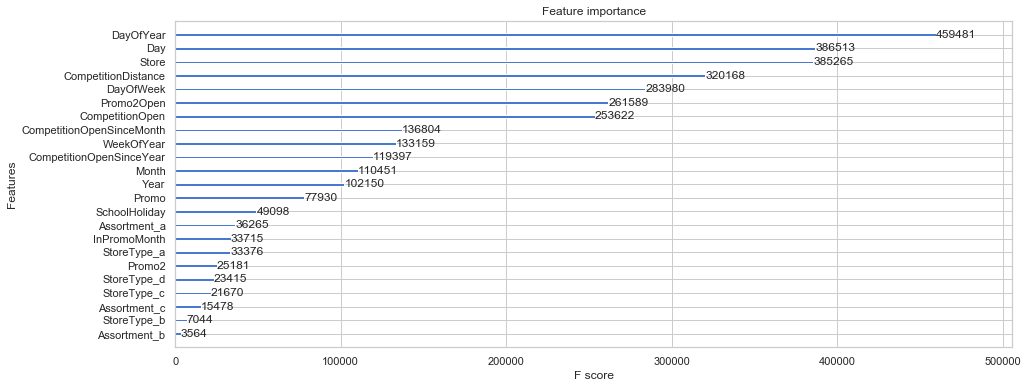

In [5]:
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns

% matplotlib inline

sns.set(style='whitegrid', palette='muted')

m.save_model('data/model.joblib.dat')

fig, ax = plt.subplots(figsize=(15, 6))
xgb.plot_importance(m.bst, ax=ax)
plt.show()

### 对测试集进行预测

In [6]:
data_test = preprocessing.combine(data_test, data_store)
X_test = preprocessing.transform(data_test, dtype='test')
y_pred = m.predict(X_test[X_train.columns])
y_sub = pd.DataFrame(data=list(zip(range(1, y_pred.shape[0] + 1), y_pred)), columns=['Id', 'Sales'])
y_sub.to_csv('data/submission.csv', index=False)

### 可视化结果

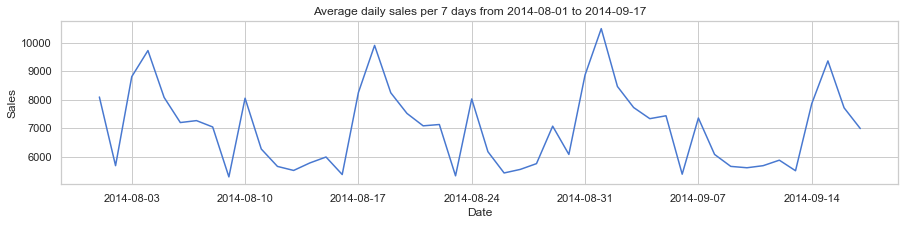

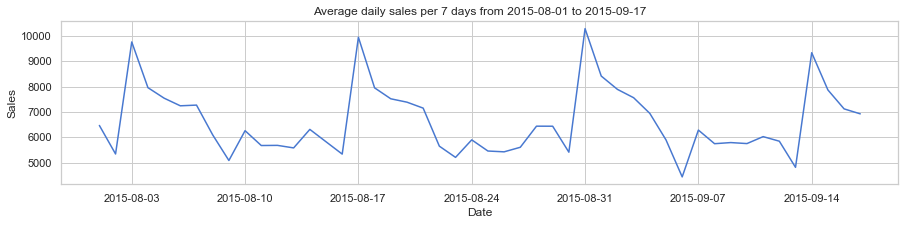

In [7]:
data_train_sales = pd.concat([X_train, y_train], axis=1)
data_train_sales['Date'] = pd.to_datetime(data_train_sales[['Year', 'Month', 'Day']])
data_train_sales = data_train_sales[(data_train_sales['Date'] >= '2014-08-01') & (data_train_sales['Date'] <= '2014-09-17')]
data_test_sales = pd.concat([X_test, pd.Series(y_pred, name='Sales')], axis=1)
data_test_sales['Date'] = pd.to_datetime(data_test_sales[['Year', 'Month', 'Day']])
data_train_sales_1 = data_train_sales.groupby(pd.Grouper(key='Date', freq='D')).mean()
data_test_sales_1 = data_test_sales.groupby(pd.Grouper(key='Date', freq='D')).mean()

plt.figure(figsize=(15, 3))
sns.lineplot(x=data_train_sales_1.index, y=data_train_sales_1['Sales']).set_title('Average daily sales per 7 days from 2014-08-01 to 2014-09-17')
plt.show()
plt.figure(figsize=(15, 3))
sns.lineplot(x=data_test_sales_1.index, y=data_test_sales_1['Sales']).set_title('Average daily sales per 7 days from 2015-08-01 to 2015-09-17')
plt.show()